<a href="https://colab.research.google.com/github/AmlanSamanta/TensorFlow_Examples/blob/main/MNISTDigitsSeqNNClassifier_Keras%26Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parameters and Imports

In [1]:
BATCH_SIZE = 128
EPOCHS = 10

# MNIST dataset is sourced from the files hosted on a public GCS bucket
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


##Utility methods

In [2]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. 
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

##Parse data files and prepare training and validation datasets

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8) # the imagebyte data is decoded into images
    image = tf.cast(image, tf.float32)/256.0 # image conversion in floating point values between 0 and 1
    image = tf.reshape(image, [28*28]) # reshape it as flat array of pixels size 28*28 expected by the dense layer
    return image
  
def load_dataset(image_file, label_file):
    # dedicated fixed record function of tf.data API is used to load the dataset in image bytes
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16) # applying the function using map
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset)) # dataset of pairs (image, label)
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True) # shuffles it with a buffer of 5000 elements
    dataset = dataset.repeat() # loops the dataset for training on it multiple epochs
    dataset = dataset.batch(batch_size, drop_remainder=True) # pulls multiple images and labels together into a mini-batch;drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # can use the CPU to prepare the next batch while the current batch is being trained on the GPU - fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 images in eval dataset, all in one batch
    dataset = dataset.repeat() 
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)


##Let's have a look at the data

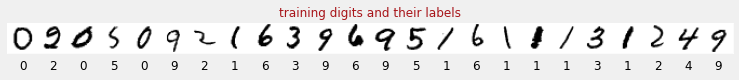

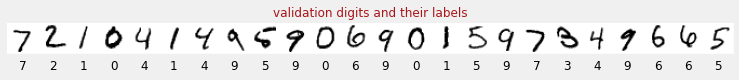

In [4]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

##Model building

In [10]:
# model is straight sequence of layers - here it's having just one dense layer with 10 neurons
model = tf.keras.Sequential(
  [
      # to let Keras know the shape of input vector - flat vectors of pixel values of size 28*28
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

# configuring the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


##Train and validate model

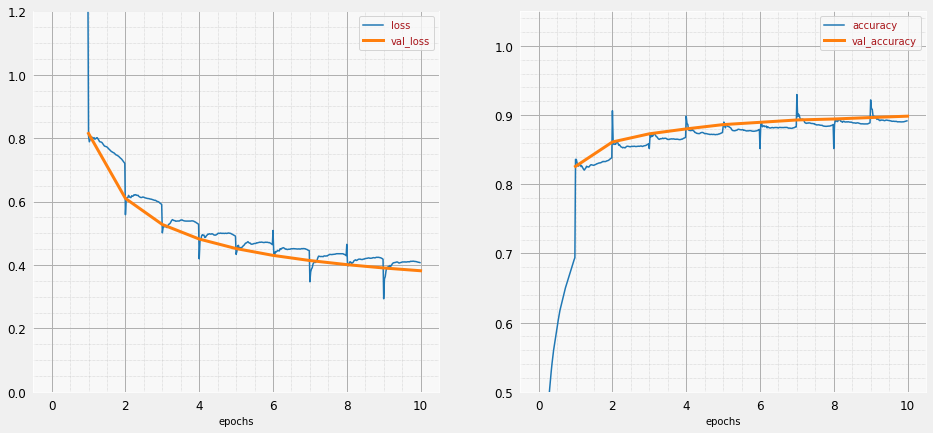

468/468 [==============================] - 4s 9ms/step - loss: 0.4064 - accuracy: 0.8919 - val_loss: 0.3817 - val_accuracy: 0.8984


In [11]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
# passing in both the training and validation datasets. By default, Keras runs a round of validation at the end of each epoch.
# dynamically updating training plot using callback utility of Keras
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

In [12]:
# Adding more layers with sigmoid activation
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='sigmoid'),
      tf.keras.layers.Dense(60, activation='sigmoid'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 200)               157000    
                                                                 
 dense_6 (Dense)             (None, 60)                12060     
                                                                 
 dense_7 (Dense)             (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


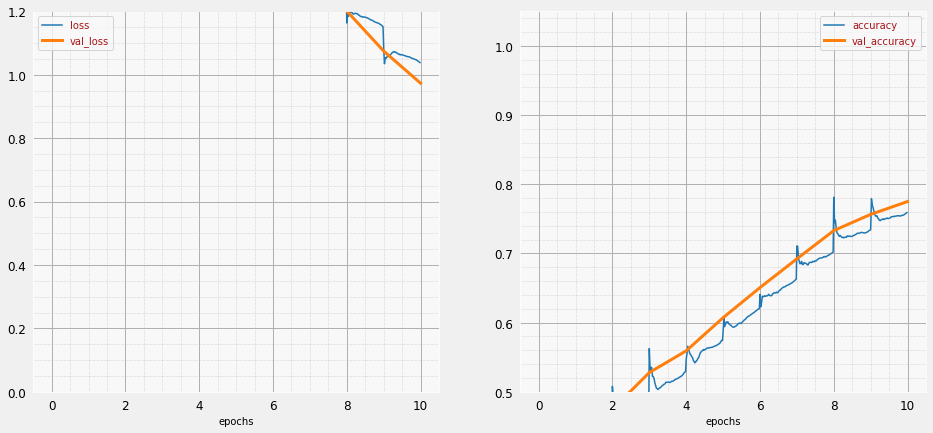

468/468 [==============================] - 5s 10ms/step - loss: 1.0366 - accuracy: 0.7597 - val_loss: 0.9732 - val_accuracy: 0.7750


In [13]:
# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

# Sigmoid squashes all values between 0 and 1 and when repeatedly done, neuron outputs and their gradients can vanish entirely

In [15]:
# With ReLu activation and Adam optimizer for special treatment in deep nets
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 200)               157000    
                                                                 
 dense_12 (Dense)            (None, 60)                12060     
                                                                 
 dense_13 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


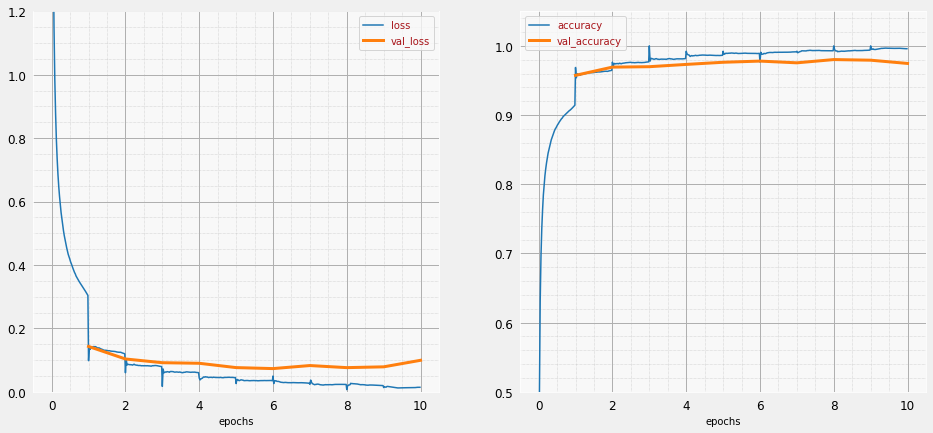

468/468 [==============================] - 4s 9ms/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.0994 - val_accuracy: 0.9746


In [16]:
# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

In [17]:
#controlling learning rate - using an actual instance of Adam optimizer and tweaking its one of the config params
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
# lr is increased from default 0.001 of predefined Adam to 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 200)               157000    
                                                                 
 dense_15 (Dense)            (None, 60)                12060     
                                                                 
 dense_16 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


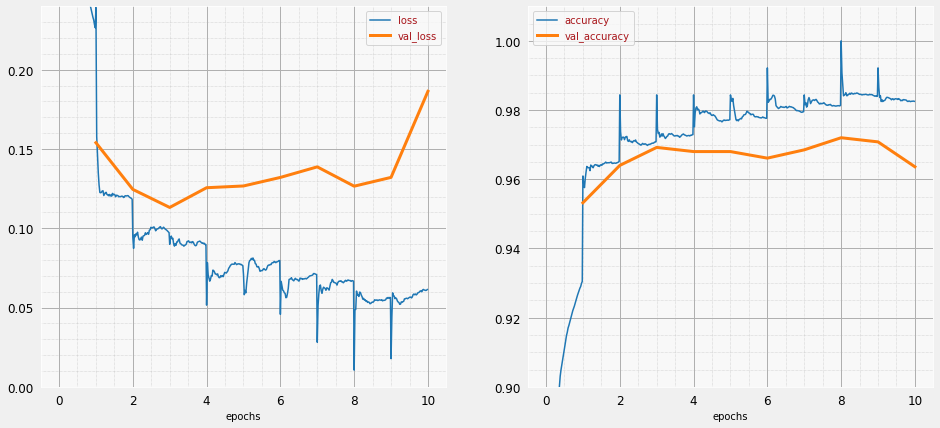

468/468 [==============================] - 5s 11ms/step - loss: 0.0613 - accuracy: 0.9826 - val_loss: 0.1864 - val_accuracy: 0.9636


In [18]:
# for better viz zoom factor is bumped
plot_training = PlotTraining(sample_rate=10, zoom=5)
# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

In [19]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 200)               157000    
                                                                 
 dense_18 (Dense)            (None, 60)                12060     
                                                                 
 dense_19 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<ipython-input-2-aaa4f230fd33>:83: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


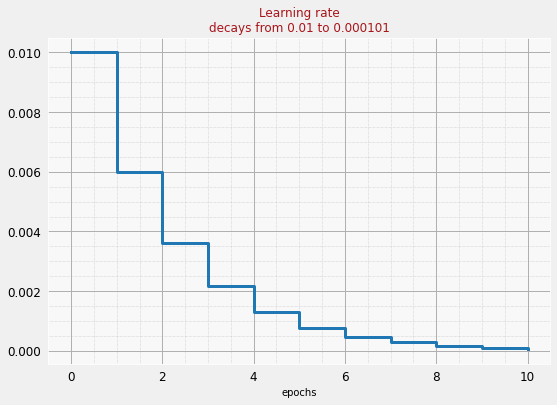

In [20]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)


plot_training = PlotTraining(sample_rate=10, zoom=5)

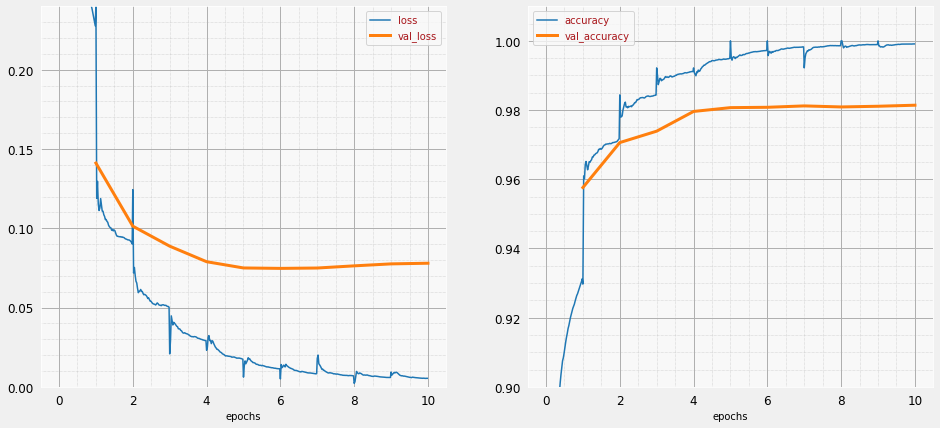

468/468 [==============================] - 5s 10ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0779 - val_accuracy: 0.9814 - lr: 1.0078e-04


In [21]:
# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
# lr is increased fast in starting and then decayed exponentially using a Keras callback
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])

In [22]:
# Let's go even deeper
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 200)               157000    
                                                                 
 dense_21 (Dense)            (None, 100)               20100     
                                                                 
 dense_22 (Dense)            (None, 60)                6060      
                                                                 
 dense_23 (Dense)            (None, 30)                1830      
                                                                 
 dense_24 (Dense)            (None, 10)                310       
                                                                 
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


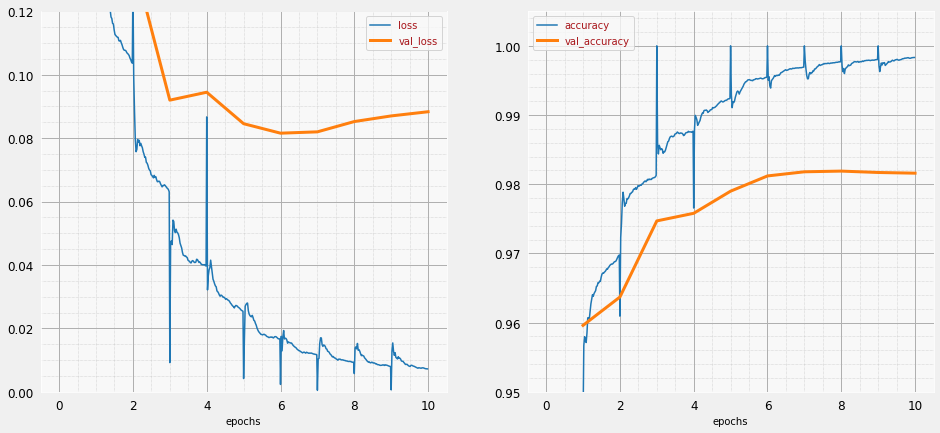

468/468 [==============================] - 5s 10ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0883 - val_accuracy: 0.9816 - lr: 1.0078e-04


In [23]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)

# zoom factor is again bumped for better viz
plot_training = PlotTraining(sample_rate=10, zoom=10)

# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])

# See the val loss are getting -vely impacted inspite of net change - as the val data has not been seen by net

In [24]:
# tackling overfitting - dropout


model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 200)               157000    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 60)                6060      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_28 (Dense)            (None, 30)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


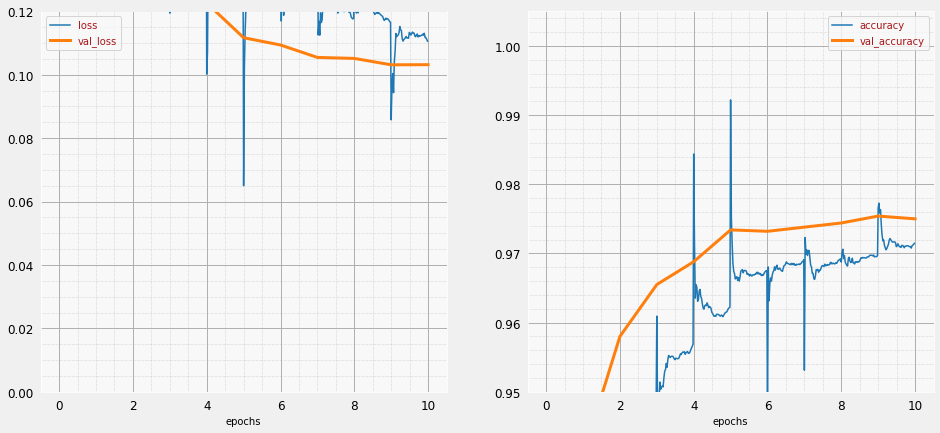

468/468 [==============================] - 5s 11ms/step - loss: 0.1103 - accuracy: 0.9715 - val_loss: 0.1032 - val_accuracy: 0.9750 - lr: 1.0078e-04


In [25]:
plot_training = PlotTraining(sample_rate=10, zoom=10)

# Retraining
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])

##Visualize predictions

1/1 [==============================] - 0s 81ms/step


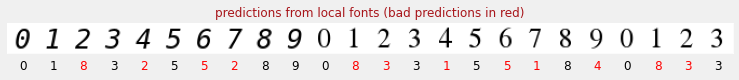

1/1 [==============================] - 0s 55ms/step


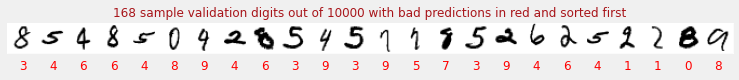

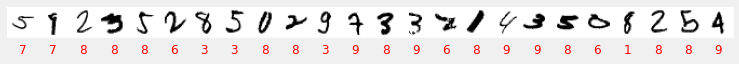

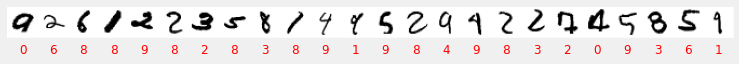

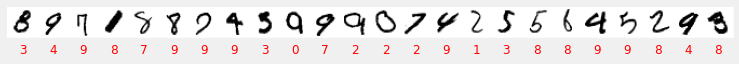

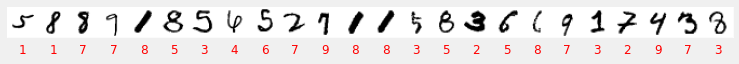

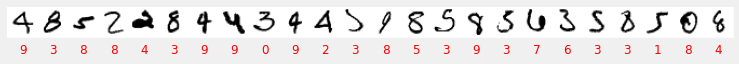

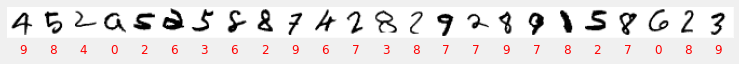

In [7]:
# getting prediction from my model - recognize a set of printed digits rendered from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1) # find out which probability is the highest among a vector of 10 probabilities from its final "softmax" in my NN
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

1/1 [==============================] - 0s 73ms/step


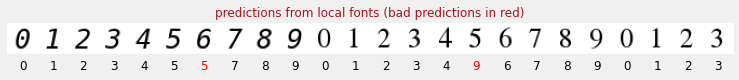

1/1 [==============================] - 0s 136ms/step


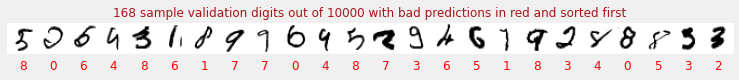

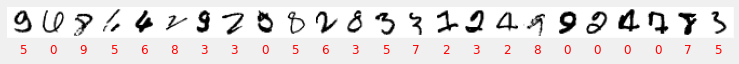

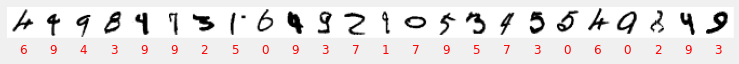

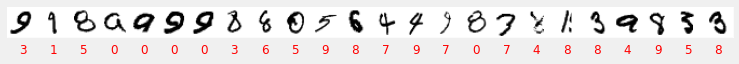

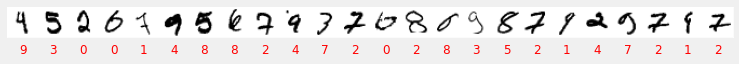

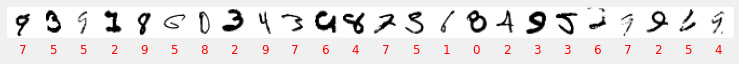

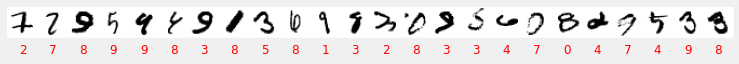

In [26]:
#Visualize pred with new network model
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1) # find out which probability is the highest among a vector of 10 probabilities from its final "softmax" in my NN
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)